# GGL: Compare CCL against GGL correlation benchmark

In [2]:
import numpy as np
import pylab as plt
import pyccl as ccl
from scipy.interpolate import interp1d

import matplotlib

%matplotlib inline

Set up font sizes, etc.

In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

## Benchmark cosmology

In [4]:
cosmo_ccl7 = ccl.Cosmology(
    Omega_c=0.3, Omega_b=0.0, h=0.7, sigma8 = 0.8, n_s=0.96, Neff=0,
    transfer_function='bbks', matter_power_spectrum='linear', Omega_g=0)

cosmo_list = [
    cosmo_ccl7]

## Redshift histograms
One of the figures of the paper shows the redshift distributions of two redshift histograms used in the computation of different quantities for the validation of `CCL`. Here are those two redshift distributions:

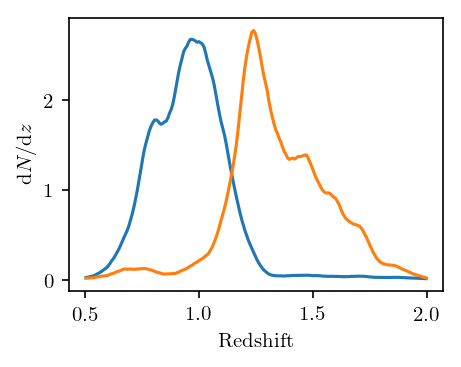

<Figure size 900x600 with 0 Axes>

In [5]:
bin_histo1=np.loadtxt('../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt')
bin_histo2=np.loadtxt('../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt')
plt.figure(figsize=fig_size);
plt.gcf().subplots_adjust(**plot_adjust)
plt.ylabel(r'${\rm d}N/{\rm d}z$');
plt.xlabel('Redshift');
plt.plot(bin_histo1[:,0],bin_histo1[:,1])
plt.plot(bin_histo2[:,0],bin_histo2[:,1])
plt.savefig('dNdz_codecomp.pdf');
plt.show();
plt.clf();

## GGL angular power spectra

In what follows, we test the accuracy of the angular power spectra predicted by CCL. 

In [6]:
accuracy = 1e-3

#Redshift distribution
zmean1=1.0; zmean2=1.5;
sigz1=0.15; sigz2=0.15;
nzs=512;

#Analytic redshift distributions
z_a_1=np.linspace(zmean1-5*sigz1,zmean1+5*sigz1,nzs);
z_a_2=np.linspace(zmean2-5*sigz2,zmean2+5*sigz2,nzs);
pz_a_1=np.exp(-0.5*((z_a_1-zmean1)/sigz1)**2)
pz_a_2=np.exp(-0.5*((z_a_2-zmean2)/sigz2)**2)
#Bias parameters for these distributions
bz_a_1=np.ones_like(z_a_1); bz_a_2=np.ones_like(z_a_2);

#Binned redshift distributions and biases
z_h_1,pz_h_1=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin1_histo.txt",unpack=True)
z_h_2,pz_h_2=np.loadtxt("../tests/benchmark/codecomp_step2_outputs/bin2_histo.txt",unpack=True)
bz_h_1=np.ones_like(z_h_1); bz_h_2=np.ones_like(z_h_2);

zarrs={'analytic':{'b1':{'z':z_a_1,'nz':pz_a_1,'bz':bz_a_1},'b2':{'z':z_a_2,'nz':pz_a_2,'bz':bz_a_2}},
      'histo':{'b1':{'z':z_h_1,'nz':pz_h_1,'bz':bz_h_1},'b2':{'z':z_h_2,'nz':pz_h_2,'bz':bz_h_2}}}

#Initialize tracers
cosmo_cls=cosmo_list[0]
cl_ccl={}
ells=np.arange(0,3001)
cfac=np.ones(3001)
for nztyp in ['analytic','histo'] :
    cl_ccl[nztyp]={}
    za=zarrs[nztyp]
    trcrNC=ccl.NumberCountsTracer(cosmo_cls,has_rsd=False,
                                    dndz=(za['b1']['z'],za['b1']['nz']),
                                    bias=(za['b1']['z'],za['b1']['bz']))
    trcrWL=ccl.WeakLensingTracer(cosmo_cls, dndz=(za['b2']['z'],za['b2']['nz']))
    #Compute ccl predictions
    cfac[2:]=(ells[2:]+0.5)*(ells[2:]+0.5)/np.sqrt((ells[2:]+2.)*(ells[2:]+1.)*ells[2:]*(ells[2:]-1.))
    cl_ccl[nztyp]=ccl.angular_cl(cosmo_cls,trcrNC,trcrWL,ells)*cfac



## GGL correlation function

In [7]:
import scipy

#Read benchmarks and expected LSST error bars
bench_err=np.loadtxt("../tests/benchmark/cov_corr/sigma_ggl_Nbin5")
sig_wt_spline=scipy.interpolate.interp1d(bench_err[:,0]/60.,bench_err[:,1])

corr_bench={}
for nztyp in ['analytic'] :
    corr_bench[nztyp]={}
    corr_bench[nztyp]=np.genfromtxt("../tests/benchmark/run_b1b2"+nztyp+"_log_wt_dl.txt",names=('theta','xi'))
    
theta_deg=corr_bench[nztyp]['theta']

In [8]:
#Assume that c_ell are computed above in the Angular_cl benchmark
#If you haven't run that cell, please scroll up to run it.
#Then proceed to compute the relavent correlation functions: clustering and lensing auto-correlations.
corr_fftlog={}
corr_bessel={}
for nztyp in ['analytic'] :
    za=zarrs[nztyp]
    corr_fftlog[nztyp]={}
    corr_fftlog[nztyp]=ccl.correlation(cosmo_cls, ells, cl_ccl[nztyp], theta_deg,corr_type='GL', method='FFTLog')
    corr_bessel[nztyp]={}
    corr_bessel[nztyp]=ccl.correlation(cosmo_cls, ells, cl_ccl[nztyp], theta_deg,corr_type='GL', method='Bessel')

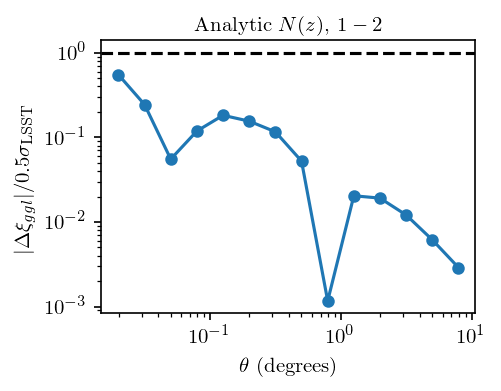

<Figure size 900x600 with 0 Axes>

In [10]:
accuracy = 1

for nztyp in ['analytic'] :
    plt.figure(figsize=fig_size)
    plt.plot(theta_deg[1:],np.abs(corr_bench[nztyp]['xi'][1:]-corr_fftlog[nztyp][1:])/(0.5*sig_wt_spline(theta_deg[1:])),"o-",c=color_map(0), ms=5,label='FFTLog')
    #plt.plot(theta_deg[1:],np.abs(corr_bench[nztyp]['xi'][1:]-corr_bessel[nztyp][1:])/(0.5*sig_wt_spline(theta_deg[1:])),"o-",c=color_map(1), ms=5,label='Brute-force')
    plt.xscale('log')
    plt.yscale('log')
    plt.axhline(accuracy, c="k", ls="--")
    plt.xlabel(r'$\theta$ (degrees)')
    plt.ylabel(r'$|\Delta \xi_{ggl}|/0.5\sigma_{\rm LSST}$')
    plt.title(r'Analytic $N(z)$, $1-2$')
    plt.gcf().subplots_adjust(**plot_adjust)
    plt.savefig('projected_xiggl_error_comparison_'+nztyp+'.pdf')
    plt.show()
    plt.clf()